In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as DT
import yfinance as yf
import numpy as np
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
import pandas_market_calendars as mcal
import datetime
#from mpl_toolkits.mplot3d import axes3d
import scipy as sp
import scipy.interpolate
from scipy.stats import norm
import math

import numpy as np
import pandas as pd
from scipy.stats import t, norm
from pycopula.copula import GaussianCopula

In [34]:
def load_data(file_path):
    data = pd.read_csv(file_path)
    data.index = pd.to_datetime(data['Date'], format='%m/%d/%Y')
    data['Price'] = data['Price'].str.replace(',', '').astype(float)
    data['Log Return'] = np.log(data['Price'] / data['Price'].shift(1))
    data = data.dropna(subset=['Log Return'])
    return data

file_path = "../Data CSV/SMI Historical Data.csv"
smi = load_data(file_path)

file_path = "../Data CSV/S&P 500 Historical Data.csv"
sp500 = load_data(file_path)

file_path = "../Data CSV/Euro Stoxx 50 Historical Data.csv"
stoxx50 = load_data(file_path)

In [35]:
common_dates = list(set(stoxx50.index).intersection(set(smi.index).intersection(set(sp500.index))))
## losing data on dates, simulation also assuming common dates, losing about 14% data
print("Data Loss:", (3*len(common_dates))/(len(stoxx50)+len(smi)+len(sp500)))

def load_data(file_path):
    data = pd.read_csv(file_path)
    data.index = pd.to_datetime(data['Date'], format='%m/%d/%Y')
    data = data[data.index.isin(common_dates)]
    data['Price'] = data['Price'].str.replace(',', '').astype(float)
    data['Log Return'] = np.log(data['Price'] / data['Price'].shift(1))
    data.drop(columns=["Change %"], errors = "Ignore", inplace = True)
    data = data.dropna(subset=['Log Return'])
    return data

file_path = "../Data CSV/SMI Historical Data.csv"
smi = load_data(file_path)

file_path = "../Data CSV/S&P 500 Historical Data.csv"
sp500 = load_data(file_path)

file_path = "../Data CSV/Euro Stoxx 50 Historical Data.csv"
stoxx50 = load_data(file_path)

returns = pd.DataFrame({
    'SMI': smi['Log Return'],
    'STOXX50': stoxx50['Log Return'],
    'SP500': sp500['Log Return']
}).dropna()

chf = pd.read_csv("../Data CSV/USD_CHF Historical Data.csv")
chf.index = pd.DatetimeIndex(chf["Date"])
eur = pd.read_csv("../Data CSV/USD_EUR Historical Data.csv")
eur.index = pd.DatetimeIndex(eur["Date"])

Data Loss: 0.8628979857050032


## Simulation using Student T

In [4]:
params_smi = t.fit(returns['SMI'])
params_stoxx50 = t.fit(returns['STOXX50'])
params_sp500 = t.fit(returns['SP500'])

corr_matrix = returns.corr()
chol_matrix = np.linalg.cholesky(corr_matrix)

In [5]:
n_simulations = 1
n_timesteps = 30

z = np.random.normal(size=(n_timesteps, n_simulations, 3))
correlated_z = np.matmul(z, chol_matrix.T)
u = norm.cdf(correlated_z)

sim_smi = t.ppf(u[:, :, 0], *params_smi)
sim_stoxx50 = t.ppf(u[:, :, 1], *params_stoxx50)
sim_sp500 = t.ppf(u[:, :, 2], *params_sp500)

initial_prices = {
    'SMI': smi['Price'].iloc[-1],
    'STOXX50': stoxx50['Price'].iloc[-1],
    'SP500': sp500['Price'].iloc[-1]
}

price_paths_smi = initial_prices['SMI'] * np.exp(np.cumsum(sim_smi, axis=0))
price_paths_stoxx50 = initial_prices['STOXX50'] * np.exp(np.cumsum(sim_stoxx50, axis=0))
price_paths_sp500 = initial_prices['SP500'] * np.exp(np.cumsum(sim_sp500, axis=0))

price_paths = {
    'SMI': price_paths_smi,
    'STOXX50': price_paths_stoxx50,
    'SP500': price_paths_sp500
}

In [6]:
corr_matrix

,SMI,STOXX50,SP500
SMI,1.000000,0.792476,0.500997
STOXX50,0.792476,1.000000,0.592506
SP500,0.500997,0.592506,1.000000


## Simulation using GBM with the CIR model

Using an MLE to estimate paramters for the CIR model

In [44]:
interest_rates["United States Treasury 10-YR Rates"].dropna()

0       1.92
1       1.88
2       1.82
3       1.84
4       1.81
        ... 
1246    4.31
1247    4.26
1248    4.42
1249    4.31
1250    4.30
Name: United States Treasury 10-YR Rates, Length: 1251, dtype: float64

In [42]:
from scipy.optimize import minimize

# Load data
interest_rates = pd.read_excel("../Data CSV/US Interest Rates.xlsx")
interest_rates.columns = interest_rates.columns.str.strip()
interest_rates = interest_rates.dropna(subset=["United States Treasury 10-YR Rates"])
interest_rates["United States Treasury 10-YR Rates"] = pd.to_numeric(
    interest_rates["United States Treasury 10-YR Rates"], errors="coerce"
)
r = interest_rates["United States Treasury 10-YR Rates"].dropna().values

print(r)

dt = 1 / 252  # Time step

# log-likelihood function assumes:
# dr ~ N (mean_increment, variance_increment)

# Define negative log-likelihood function
def negative_log_likelihood(params, r, dt):
    kappa, theta, sigma_r = params
    if kappa <= 0 or sigma_r <= 0:
        return np.inf
    log_likelihood = 0
    for t in range(len(r) - 1):
        dr = r[t + 1] - r[t]
        mean_increment = kappa * (theta - r[t]) * dt
        variance_increment = sigma_r**2 * r[t] * dt
        if variance_increment <= 0:
            return np.inf
        likelihood_t = -0.5 * np.log(2 * np.pi * variance_increment) - 0.5 * (
            (dr - mean_increment) ** 2 / variance_increment
        )
        log_likelihood += likelihood_t
    return -log_likelihood

# Initial guesses and bounds
initial_vals = [0.1, np.mean(r), np.std(r)]
bounds = ((1e-5, None), (None, None), (1e-5, None))

# Optimization
result = minimize(
    negative_log_likelihood, initial_vals, args=(r, dt), bounds=bounds, method="L-BFGS-B"
)

kappa, theta, sigma_r = result.x
print("Fitted Parameters:")
print("kappa:", kappa)
print("theta:", theta)
print("sigma_r:", sigma_r)

[1.92 1.88 1.82 ... 4.42 4.31 4.3 ]
Fitted Parameters:
kappa: 0.12446876393245775
theta: 6.471998101849824
sigma_r: 0.6839318363088617


In [43]:
r

array([1.92, 1.88, 1.82, ..., 4.42, 4.31, 4.3 ])

{'SMI': np.float64(0.15212714616824494), 'STOXX50': np.float64(0.1947607348796791), 'SP500': np.float64(0.17623741746668914)}
{'SMI': array([[8270.46, 8270.46, 8270.46, ..., 8270.46, 8270.46, 8270.46],
       [   0.  ,    0.  ,    0.  , ...,    0.  ,    0.  ,    0.  ],
       [   0.  ,    0.  ,    0.  , ...,    0.  ,    0.  ,    0.  ],
       ...,
       [   0.  ,    0.  ,    0.  , ...,    0.  ,    0.  ,    0.  ],
       [   0.  ,    0.  ,    0.  , ...,    0.  ,    0.  ,    0.  ],
       [   0.  ,    0.  ,    0.  , ...,    0.  ,    0.  ,    0.  ]]), 'STOXX50': array([[3074.43, 3074.43, 3074.43, ..., 3074.43, 3074.43, 3074.43],
       [   0.  ,    0.  ,    0.  , ...,    0.  ,    0.  ,    0.  ],
       [   0.  ,    0.  ,    0.  , ...,    0.  ,    0.  ,    0.  ],
       ...,
       [   0.  ,    0.  ,    0.  , ...,    0.  ,    0.  ,    0.  ],
       [   0.  ,    0.  ,    0.  , ...,    0.  ,    0.  ,    0.  ],
       [   0.  ,    0.  ,    0.  , ...,    0.  ,    0.  ,    0.  ]]), 'SP500': ar

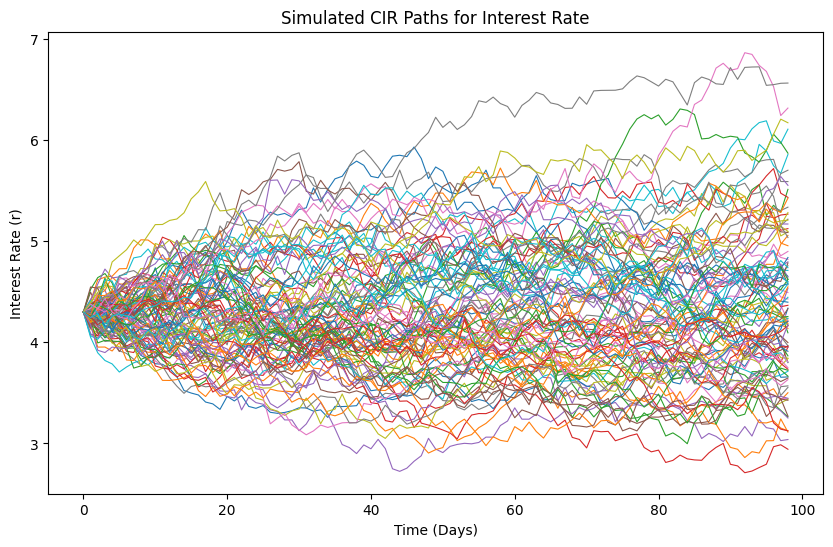

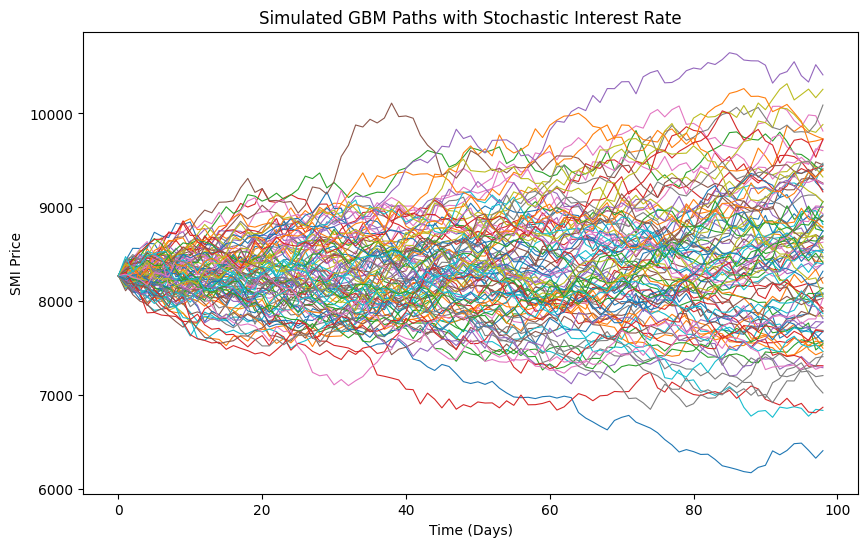

In [48]:
date = '2024-08-01'
n_simulations = 100
n_timesteps = len(pd.bdate_range(start='2024-08-01',end='2024-12-16'))

mu = {}
sigma = {}
for index in ['SMI', 'STOXX50', 'SP500']:
    mean_return = returns[index].mean()
    variance = returns[index].var()
    mu[index] = mean_return
    sigma[index] = np.sqrt(variance)*np.sqrt(252)
print(sigma)

corr_matrix = returns.corr()
chol_matrix = np.linalg.cholesky(corr_matrix)

Z = np.random.normal(size=(n_timesteps, n_simulations, 3))
Z_flat = Z.reshape(-1, 3)
Z_correlated_flat = Z_flat @ chol_matrix.T
Z_correlated = Z_correlated_flat.reshape(n_timesteps, n_simulations, 3)

initial_prices = {
    'SMI': smi['Price'].iloc[-1],
    'STOXX50': stoxx50['Price'].iloc[-1],
    'SP500': sp500['Price'].iloc[-1]
}

# print(smi['Price'])
# print(stoxx50['Price'])
# print(sp500['Price'])

price_paths = {index: np.zeros((n_timesteps + 1, n_simulations)) for index in ['SMI', 'STOXX50', 'SP500']}
for index in ['SMI', 'STOXX50', 'SP500']:
    price_paths[index][0] = initial_prices[index]
print(price_paths)

initial_rate = r[-1]
r_paths = np.zeros((n_timesteps + 1, n_simulations))
r_paths[0, :] = initial_rate

print(r_paths)

for i in range(1, n_timesteps + 1):
    Z_r = np.random.normal(size=n_simulations)
    r_t_prev = r_paths[i - 1]
    dr = kappa * (theta - r_t_prev) * dt + sigma_r * np.sqrt(r_t_prev * dt) * Z_r
    r_paths[i] = np.maximum(r_t_prev + dr, 0)

    for idx, index in enumerate(['SMI', 'STOXX50', 'SP500']):
        #drift_term = (r_paths[i] - 0.5 * sigma[index] ** 2) * dt
        drift_term = (np.log(1+r_paths[i]*0.01) - 0.5 * sigma[index] ** 2) * dt
        diffusion_term = sigma[index] * np.sqrt(dt) * Z_correlated[i - 1, :, idx]
        price_paths[index][i] = price_paths[index][i - 1] * np.exp(drift_term + diffusion_term)

for index in ['SMI', 'STOXX50', 'SP500']:
    price_paths[index] = price_paths[index].transpose()

plt.figure(figsize=(10, 6))
for i in range(n_simulations):
    plt.plot(range(n_timesteps + 1), r_paths[:, i], lw=0.8)
plt.xlabel("Time (Days)")
plt.ylabel("Interest Rate (r)")
plt.title("Simulated CIR Paths for Interest Rate")
plt.show()

plt.figure(figsize=(10, 6))
for i in range(n_simulations):
    plt.plot(range(n_timesteps + 1), price_paths['SMI'][i, :], lw=0.8)
plt.xlabel("Time (Days)")
plt.ylabel("SMI Price")
plt.title("Simulated GBM Paths with Stochastic Interest Rate")
plt.show()

In [7]:
import pandas as pd

def load_data(file_path, date_column='Period'):
    """
    Load CSV data, parse the date column, and return a DataFrame.

    Parameters:
    - file_path (str): Path to the CSV file.
    - date_column (str): Column name containing date information.

    Returns:
    - pd.DataFrame: Loaded and processed DataFrame.
    """
    try:
        data = pd.read_csv(file_path)
        if date_column in data.columns:
            data[date_column] = pd.to_datetime(data[date_column])
            data.set_index(date_column, inplace=True)
        else:
            print(f"Warning: '{date_column}' column not found in {file_path}")
        return data
    except FileNotFoundError:
        print(f"Error: File not found - {file_path}")
        return pd.DataFrame()
    except Exception as e:
        print(f"Error: An error occurred while loading {file_path} - {e}")
        return pd.DataFrame()

# Load datasets
smi_file_path = "../Data CSV/EurozoneMarkov.csv"
smi_markov = load_data(smi_file_path)

sp500_file_path = "../Data CSV/SwitzerlandMarkov.csv"
sp500_markov = load_data(sp500_file_path)

stoxx50_file_path = "../Data CSV/USAMarkov.csv"
stoxx50_markov = load_data(stoxx50_file_path)

# Display one of the datasets
print("smi markov:")
print(smi_markov)
print("sp500:")
print(sp500_markov)
print("stoxx50:")
print(stoxx50_markov)



smi markov:
            GDP_YoY%  CPI_YoY%  Combined_Regime
Period                                         
2000-03-31    0.0426      1.96                4
2000-04-30    0.0426      1.71                4
2000-05-31    0.0426      1.76                4
2000-06-30    0.0467      2.14                4
2000-07-31    0.0467      2.09                4
...              ...       ...              ...
2024-04-30    0.0046      2.37                3
2024-05-31    0.0046      2.57                3
2024-06-30    0.0060      2.52                3
2024-07-31    0.0060      2.58                3
2024-08-31    0.0060      2.17                3

[294 rows x 3 columns]
sp500:
            GDP_YoY%  CPI_YoY%  Combined_Regime
Period                                         
2000-03-31    0.0432      1.48                2
2000-04-30    0.0432      1.40                2
2000-05-31    0.0432      1.58                2
2000-06-30    0.0410      1.84                2
2000-07-31    0.0410      1.89               

In [29]:
# Reindex the 'Combined_Regime' to daily frequency, forward-filling
smi_regime_daily = smi_markov['Combined_Regime'].reindex(returns.index, method='ffill')
sp500_regime_daily = sp500_markov['Combined_Regime'].reindex(returns.index, method='ffill')
stoxx50_regime_daily = stoxx50_markov['Combined_Regime'].reindex(returns.index, method='ffill')

# Add the regimes to the returns DataFrame
returns['SMI_Regime'] = smi_regime_daily
returns['SP500_Regime'] = sp500_regime_daily
returns['STOXX50_Regime'] = stoxx50_regime_daily

# Drop rows with missing regime data
returns.dropna(subset=['SMI_Regime', 'SP500_Regime', 'STOXX50_Regime'], inplace=True)

In [9]:
returns

,SMI,STOXX50,SP500,SMI_Regime,SP500_Regime,STOXX50_Regime
Date,,,,,,
2024-10-28,0.011291,0.003994,-0.001613,3,1,3
2024-10-25,-0.004420,-0.005395,-0.002648,3,1,3
2024-10-24,-0.000900,-0.001547,0.000300,3,1,3
2024-10-23,-0.002133,-0.002617,-0.002143,3,1,3
2024-10-22,0.001335,0.003399,0.009234,3,1,3
...,...,...,...,...,...,...
2014-01-09,-0.008309,-0.004485,-0.002337,1,3,1
2014-01-08,0.006838,0.006580,-0.000326,1,3,1
2014-01-07,-0.004009,0.000096,0.000218,1,3,1


In [10]:
assets = ['SMI', 'SP500', 'STOXX50']
regime_params = {}

for asset in assets:
    regime_params[asset] = {}
    for regime in returns[asset + '_Regime'].unique():
        mask = returns[asset + '_Regime'] == regime
        returns_in_regime = returns.loc[mask, asset]
        mean_return = returns_in_regime.mean()
        volatility = returns_in_regime.std()
        regime_params[asset][regime] = {
            'mean_return': mean_return,
            'volatility': volatility
        }

In [11]:
regime_params

{'SMI': {np.int64(3): {'mean_return': np.float64(-0.00028091200610514094),
   'volatility': np.float64(0.007551913402508472)},
  np.int64(4): {'mean_return': np.float64(0.00020209597096885904),
   'volatility': np.float64(0.009131288876540663)},
  np.int64(2): {'mean_return': np.float64(-0.0006339429417086586),
   'volatility': np.float64(0.009676166710764164)},
  np.int64(1): {'mean_return': np.float64(2.0785260995903307e-05),
   'volatility': np.float64(0.011560382307194618)}},
 'SP500': {np.int64(1): {'mean_return': np.float64(-0.0005962061918581951),
   'volatility': np.float64(0.008180303566778162)},
  np.int64(2): {'mean_return': np.float64(-0.00046204215025107186),
   'volatility': np.float64(0.00816799795668507)},
  np.int64(4): {'mean_return': np.float64(-0.0005576473498891349),
   'volatility': np.float64(0.013724776184802974)},
  np.int64(3): {'mean_return': np.float64(-0.00027629539108563693),
   'volatility': np.float64(0.01241592578251177)}},
 'STOXX50': {np.int64(3): {'m

In [12]:
# Example of accessing the parameters
print(regime_params['SP500'][4]['mean_return'])
print(regime_params['SMI'][4]['volatility'])

-0.0005576473498891349
0.009131288876540663


In [13]:
transition_matrices = {}

for asset in assets:
    regimes = sorted(returns[asset + '_Regime'].unique())
    n_regimes = len(regimes)
    counts = np.zeros((n_regimes, n_regimes))
    total_counts = np.zeros(n_regimes)

    asset_regimes = returns[asset + '_Regime'].values.astype(int)
    for t in range(len(asset_regimes) - 1):
        current_regime = asset_regimes[t] - 1  # Adjusting for zero-based indexing
        next_regime = asset_regimes[t + 1] - 1
        counts[current_regime, next_regime] += 1
        total_counts[current_regime] += 1

    transition_matrix = counts / total_counts[:, None]
    transition_matrices[asset] = np.nan_to_num(transition_matrix)

# Example of accessing the transition matrix
# transition_matrices['SMI']

In [14]:
date = '2024-08-01'
n_simulations = 100
n_timesteps = len(pd.bdate_range(start='2024-08-01',end='2024-12-16')) # Number of trading days in a year

regime_paths = {}

for asset in assets:
    regimes = sorted(returns[asset + '_Regime'].unique())
    n_regimes = len(regimes)
    transition_matrix = transition_matrices[asset]

    # Initialize regime paths
    regime_paths[asset] = np.zeros((n_simulations, n_timesteps), dtype=int)
    initial_regime = int(returns[asset + '_Regime'].iloc[-1]) - 1  # Zero-based index
    regime_paths[asset][:, 0] = initial_regime

    for t in range(1, n_timesteps):
        current_regimes = regime_paths[asset][:, t - 1]
        probs = transition_matrix[current_regimes]
        random_values = np.random.rand(n_simulations)
        cumulative_probs = probs.cumsum(axis=1)
        next_regimes = (random_values[:, None] < cumulative_probs).argmax(axis=1)
        regime_paths[asset][:, t] = next_regimes

In [15]:
drift = {}
volatility = {}

for asset in assets:
    drift[asset] = np.zeros((n_simulations, n_timesteps))
    volatility[asset] = np.zeros((n_simulations, n_timesteps))
    for regime in regime_params[asset]:
        mask = regime_paths[asset] == (regime - 1)
        drift[asset][mask] = regime_params[asset][regime]['mean_return']
        volatility[asset][mask] = regime_params[asset][regime]['volatility']

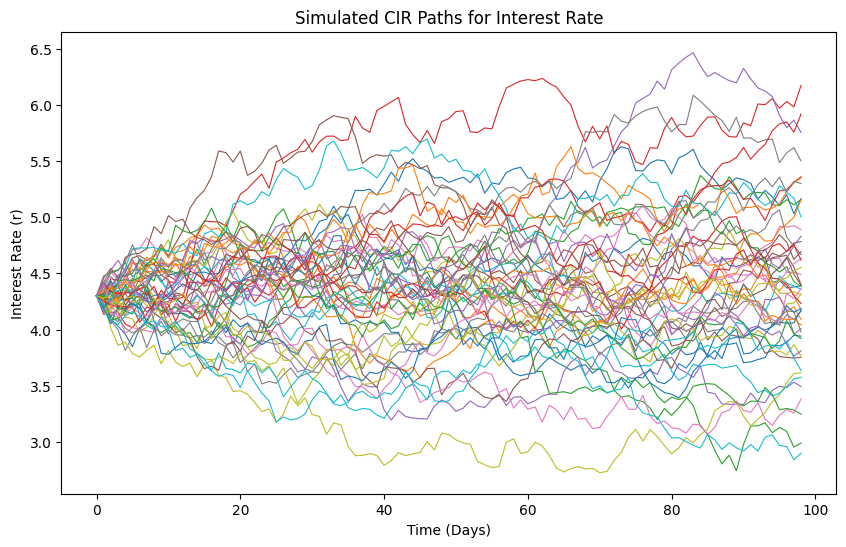

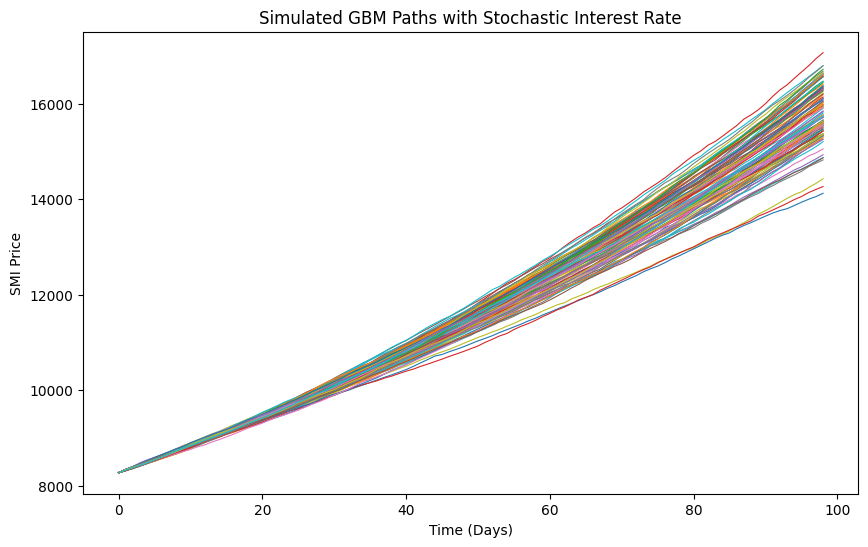

In [19]:
# Historical correlation matrix
corr_matrix = returns[['SMI', 'SP500', 'STOXX50']].corr()
chol_matrix = np.linalg.cholesky(corr_matrix)

# Generate correlated random variables
Z = np.random.normal(size=(n_simulations, n_timesteps, 3))
Z_flat = Z.reshape(-1, 3)
Z_correlated_flat = Z_flat @ chol_matrix.T
Z_correlated = Z_correlated_flat.reshape(n_simulations, n_timesteps, 3)

dt = 1 / 252  # Daily time step

# Initialize interest rate paths
initial_rate = r[-1]
r_paths = np.zeros((n_simulations, n_timesteps + 1))
r_paths[:, 0] = initial_rate

# Simulate interest rate paths
for t in range(1, n_timesteps + 1):
    Z_r = np.random.normal(size=n_simulations)
    r_t_prev = r_paths[:, t - 1]
    dr = kappa * (theta - r_t_prev) * dt + sigma_r * np.sqrt(r_t_prev * dt) * Z_r
    r_paths[:, t] = np.maximum(r_t_prev + dr, 0)

# Initialize price paths with correct dimensions
price_paths = {index: np.zeros((n_simulations, n_timesteps + 1)) for index in ['SMI', 'STOXX50', 'SP500']}
for index in ['SMI', 'STOXX50', 'SP500']:
    price_paths[index][:, 0] = initial_prices[index]

# Initialize interest rate paths
r_paths = np.zeros((n_simulations, n_timesteps + 1))
r_paths[:, 0] = initial_rate

# Simulation loop
for t in range(1, n_timesteps + 1):
    # Simulate interest rates
    Z_r = np.random.normal(size=n_simulations)
    r_t_prev = r_paths[:, t - 1]
    dr = kappa * (theta - r_t_prev) * dt + sigma_r * np.sqrt(np.maximum(r_t_prev, 0) * dt) * Z_r
    r_paths[:, t] = np.maximum(r_t_prev + dr, 0)
    r_t = r_paths[:, t]
    
    # Generate correlated random variables
    Z = np.random.normal(size=(n_simulations, 3))
    Z_correlated = Z @ chol_matrix.T

    for idx, asset in enumerate(['SMI', 'STOXX50', 'SP500']):
        # Retrieve drift and volatility based on regimes
        #drift_t = drift[asset][:, t - 1]
        #volatility_t = volatility[asset][:, t - 1]

        # Calculate drift term using the stochastic interest rate
        drift_term = (np.log(1+r_t) - 0.5 * volatility_t ** 2) * dt

        # Calculate diffusion term
        diffusion_term = volatility_t * np.sqrt(dt) * Z_correlated[:, idx]

        # Update asset prices
        price_paths[asset][:, t] = price_paths[asset][:, t - 1] * np.exp(drift_term + diffusion_term)

# Plotting

plt.figure(figsize=(10, 6))
for i in range(min(n_simulations, 50)):  # Plotting fewer paths for clarity
    plt.plot(range(n_timesteps + 1), r_paths[i, :], lw=0.8)
plt.xlabel("Time (Days)")
plt.ylabel("Interest Rate (r)")
plt.title("Simulated CIR Paths for Interest Rate")
plt.show()

plt.figure(figsize=(10, 6))
for i in range(min(n_simulations, 1000)):
    plt.plot(range(n_timesteps + 1), price_paths['SMI'][i, :], lw=0.8)
plt.xlabel("Time (Days)")
plt.ylabel("SMI Price")
plt.title("Simulated GBM Paths with Stochastic Interest Rate")
plt.show()